In [3]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import  opencv as cv2

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [5]:
import os
os.chdir('C:\\Users\\sikha\\Soft_attention_map_models')

In [6]:
df = pd.read_csv("data.csv")

In [7]:
df.head()

,filename,cls
0,animals10\butterfly\e030b20928e90021d85a5854ee...,butterfly
1,animals10\butterfly\e030b20929e90021d85a5854ee...,butterfly
2,animals10\butterfly\e030b2092be90021d85a5854ee...,butterfly
3,animals10\butterfly\e030b2092ce90021d85a5854ee...,butterfly
4,animals10\butterfly\e030b2092de90021d85a5854ee...,butterfly


<AxesSubplot: >

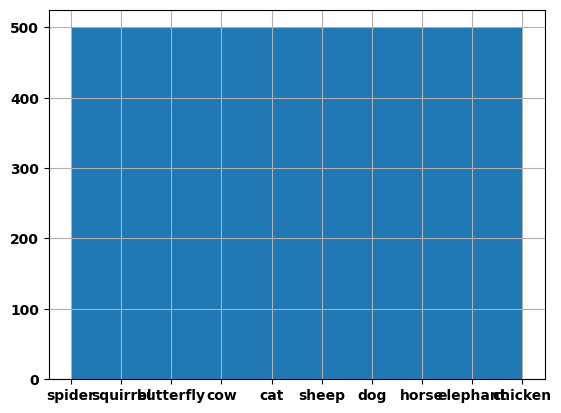

In [9]:
df = df.groupby("cls").head(500).reset_index(drop = True)
df = df.sample(frac=1).reset_index(drop=True)
df.cls.hist()

In [10]:
BATCH_SIZE = 128
IMG_SIZE = 224
NUM_CLASSES = df.cls.nunique()

In [11]:
datagen = ImageDataGenerator(
    rescale = 1/255.,
    validation_split=0.2,
)

training_generator = datagen.flow_from_dataframe (
    df, 
    x_col = "filename",
    y_col = "cls",
    batch_size = BATCH_SIZE,
    target_size = ((IMG_SIZE, IMG_SIZE)),
    subset = "training",
)

val_generator = datagen.flow_from_dataframe (
    df, 
    x_col = "filename",
    y_col = "cls",
    batch_size = BATCH_SIZE,
    target_size = ((IMG_SIZE, IMG_SIZE)),
    subset = "validation",
)


Found 3909 validated image filenames belonging to 10 classes.


C:\Users\sikha\anaconda3\envs\tf-gpu\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 114 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


Found 977 validated image filenames belonging to 10 classes.


C:\Users\sikha\anaconda3\envs\tf-gpu\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 114 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


# Model 1

In [9]:
model1=tf.keras.Sequential(
[
    tf.keras.Input(shape=(IMG_SIZE,IMG_SIZE,3)),
    tf.keras.layers.Conv2D(32,kernel_size=(3,3),activation='relu',name='C1'),
    tf.keras.layers.Conv2D(16,kernel_size=(3,3),activation='relu',name='C2'),
    tf.keras.layers.Conv2D(16,kernel_size=(3,3),activation='relu',name='C3'),
    tf.keras.layers.Conv2D(8, kernel_size=(3, 3), activation="relu",name='C4'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NUM_CLASSES, activation="softmax"),
    ]
)
   

In [10]:
model1.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [11]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 222, 222, 32)      896       
                                                                 
 C2 (Conv2D)                 (None, 220, 220, 16)      4624      
                                                                 
 C3 (Conv2D)                 (None, 218, 218, 16)      2320      
                                                                 
 C4 (Conv2D)                 (None, 216, 216, 8)       1160      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 108, 108, 8)      0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 93312)             0         
                                                        

In [ ]:
#model1.load_weights('D:/RESEARCH/POST_PHD/UPC/000_DMD_DL/0000_Paper_Drafr/Results/MODEL_1/ANIMAL10_1/epch5_33.6.h5')

In [12]:
BATCH_SIZE=128
EPOCHS=1#1,5,10,15,25
history = model1.fit(
    training_generator,
    epochs = EPOCHS,
    validation_data = val_generator
)

31/31 [==============================] - ETA: 0s - loss: 2.2400 - accuracy: 0.1837 

KeyboardInterrupt: 

In [ ]:
conda install SciPy

In [ ]:
model1.save('D:/RESEARCH/POST_PHD/UPC/000_DMD_DL/0000_Paper_Drafr/Results/MODEL_1/ANIMAL10/epch10_38.18.h5')

In [ ]:
score = model1.evaluate(val_generator)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

In [ ]:
#Iterate thru all the layers of the model
for layer in model1.layers:
    if 'conv' in layer.name:
        weights, bias= layer.get_weights()
        #print(layer.name, filters.shape)
        
        #normalize filter values between  0 and 1 for visualization
        f_min, f_max = weights.min(), weights.max()
        filters = (weights - f_min) / (f_max - f_min)  
        print(filters.shape[3])
        filter_cnt=1

# Feature Maps

In [ ]:
def build_featuremap_model(model):
    conv_layer_outputs = [layer.output for layer in model.layers if isinstance(layer, tf.keras.layers.Conv2D)]
    new_model = tf.keras.models.Model(inputs = model.inputs, outputs=conv_layer_outputs)
    new_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return new_model

In [ ]:
new_global_model = build_featuremap_model(model1)

In [ ]:
x, y = val_generator.next()

In [ ]:
conv_outs =  new_global_model(x)

In [ ]:
len(conv_outs)

In [ ]:
@tf.function
def softmax_image(image):
    orig_shape = image.shape
    return tf.reshape(tf.math.softmax(tf.reshape(image, [-1])), orig_shape)

In [ ]:
@tf.function
def normalize(heatmap):
    num = heatmap - tf.reduce_min(heatmap)
    deno = (tf.reduce_max(heatmap) - tf.reduce_min(heatmap))
    if deno == 0:
        return heatmap
    heatmap = num / deno
    return heatmap

In [ ]:
def get_feature_maps_from_outs(outs):# layers x imgs x h x w x filters
    num_layers = len(outs)
    num_imgs = outs[0].shape[0]
    img_outs = [[[] for _ in range(num_layers)] for _ in range(num_imgs)]
    for i in range(num_layers):
        for j in range(num_imgs):
            img_out = outs[i][j]
            for k in range(img_out.shape[-1]):
                img_outs[j][i].append(img_out[:, :, k])
                
    return img_outs # imgs x layers x filters x h x w

In [ ]:
img_outs = get_feature_maps_from_outs(conv_outs)

In [ ]:
soft_img_outs = [[[softmax_image(filter_out) for filter_out in layer_out] for layer_out in img_out] for img_out in img_outs]

In [ ]:
img_outs=img_outs[:50]
soft_img_outs=soft_img_outs[:50]

In [ ]:
layer_names = [layer.name for layer in model1.layers if isinstance(layer, tf.keras.layers.Conv2D)]
layer_names

In [ ]:
for img_id, img_out in enumerate(soft_img_outs):
    !mkdir "D:/RESEARCH/POST_PHD/UPC/000_DMD_DL/0000_Paper_Drafr/Results/MODEL_1/ANIMAL10/epoch10_38.18/$img_id/"
    for layer_id, layer_out in enumerate(img_out):
        for filter_id, filter_out in enumerate(layer_out):
            img = filter_out
            img = tf.image.resize(img[tf.newaxis, ..., tf.newaxis], [128, 128])
            img = tf.squeeze(img)
            plt.figure(figsize=(2,2))
            plt.imshow( img, cmap="jet")
            plt.axis('off')
            plt.savefig(f"D:/RESEARCH/POST_PHD/UPC/000_DMD_DL/0000_Paper_Drafr/Results/MODEL_1/ANIMAL10/epoch10_38.18/{img_id}/layer-{layer_id}-{layer_names[layer_id]}-{filter_id}.png",bbox_inches='tight', pad_inches=0)
            #plt.imsave(f"maps/softmax_output/{img_id}/layer-{layer_id}-{layer_names[layer_id]}-{filter_id}.jpg", img)

In [ ]:
fig = plt.figure(figsize=(10, 7))
for i in range(1,21):
    fig.add_subplot(4, 5, i)
    image_index = i-1
        plt.imshow(x_test[image_index].reshape(32, 32,3))
    pred = model1.predict(x_test[image_index].reshape(1, 32, 32, 3))
    plt.title("{}:{}".format(pred.argmax(),y_test1[i-1]))
    plt.axis('off')
    #print(pred.argmax())